#HW 10 CLUSTERING BUSINESS

#cluster time trends in NYC businesses: 
#DATA
#Census Business data:
##download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



In [ ]:
$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

$ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


#NYC zip codes shape file is here
##http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [90]:
import pandas as pd
%pylab inline
import numpy as np
import geopandas as gpd
import pylab as pl
#import kmseg
import sklearn.cluster
from sklearn import mixture
from scipy.cluster.vq import kmeans2
import random

import json
import os
import zipfile
from sklearn.cluster import k_means

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [91]:
#Loading the zipcode geo data
import urllib2

url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson"
request = urllib2.urlopen(url)
zipcode = json.load(request)

nyczip = []
for i in range (0,262):
    nyczip.append(str(zipcode['features'][i]['properties']['postalCode']))

print "Number of Zipcode:", len(nyczip)
print ""
print nyczip

Number of Zipcode: 262

['11372', '11004', '11040', '11426', '11365', '11373', '11001', '11375', '11427', '11374', '11366', '11423', '11428', '11432', '11379', '11429', '11435', '11415', '11418', '11433', '11451', '11221', '11421', '11419', '11434', '11216', '11416', '11233', '11436', '11213', '11212', '11225', '11218', '11226', '11219', '11210', '11230', '11204', '10471', '10470', '10466', '10467', '10463', '10475', '10464', '10469', '10468', '10463', '10458', '10034', '10033', '10462', '10040', '10453', '10465', '10464', '10464', '10461', '10457', '10460', '10032', '10452', '10456', '10472', '10031', '10039', '10459', '10451', '10473', '10030', '10027', '10474', '10455', '10037', '10024', '10454', '10026', '10035', '10025', '10035', '11357', '10029', '00083', '11356', '11359', '11360', '11105', '10128', '11371', '10023', '11363', '10028', '11354', '11102', '11370', '10021', '11361', '11358', '11362', '10044', '11369', '11103', '11106', '11368', '11377', '10036', '11355', '11101', '11

In [92]:
#Data is from 1994 to 2013
#format is different in 1998-2002 (header is upper case)

random.seed((1000,2000))

qw = {}
for i in range (1994,2014):
    if i in range(1998, 2003):
        fname = 'zbp' + str(i)[2:] +'totals.zip'
        #print fname
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
        df = df.rename(columns={'ZIP': 'zip', 'EST': str(i)})
        df = df[(df.zip.astype(str).isin(nyczip))]
        qw['{}'.format(i)] = df[['zip',str(i)]]
    else:
        fname = 'zbp' + str(i)[2:] +'totals.zip'
        #print fname
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
        df = df.rename(columns={'est': str(i)})
        df = df[(df.zip.astype(str).isin(nyczip))]
        qw['{}'.format(i)] = df[['zip',str(i)]]
        
#Merge the data based on zipcode
dfs = [qw['1994'], qw['1995'], qw['1996'], qw['1997'], qw['1998'],qw['1999'],qw['2000'],qw['2001'],qw['2002'],qw['2003'],qw['2004'],qw['2005'],qw['2006'],qw['2007'],qw['2008'],qw['2009'],qw['2010'],qw['2011'],qw['2012'],qw['2013'],]
df_final = reduce(lambda left,right: pd.merge(left,right,on='zip', how = 'inner'), dfs)
df_final = df_final.set_index('zip')
print "Sanity Check: Shape of the dataframe:", df_final.shape
print ""
print df_final.head()

Sanity Check: Shape of the dataframe: (230, 20)

       1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  \
zip                                                                             
10001  6999  7088  7075  7154  7254  7233  7317  7188  7141  7084  7370  7312   
10002  1784  1819  1919  2049  2003  2085  2277  2543  2269  2402  2551  2682   
10003  3256  3377  3417  3535  3649  3659  3683  3602  3616  3704  3776  3867   
10004  1115  1124  1133  1173  1176  1233  1294  1247  1253  1252  1283  1260   
10005  1076  1109  1216  1227  1270  1242  1287  1249  1244  1200  1226  1214   

       2006  2007  2008  2009  2010  2011  2012  2013  
zip                                                    
10001  7415  7549  7472  7305  7241  7227  7235  7273  
10002  2686  2685  2691  2775  2872  2912  2954  2988  
10003  3909  4049  4071  4099  4113  4159  4214  4277  
10004  1311  1370  1376  1379  1398  1404  1442  1479  
10005  1259  1273  1291  1274  1266  1301  1273

Sanity Check
mean: -0.00
std: 1.0


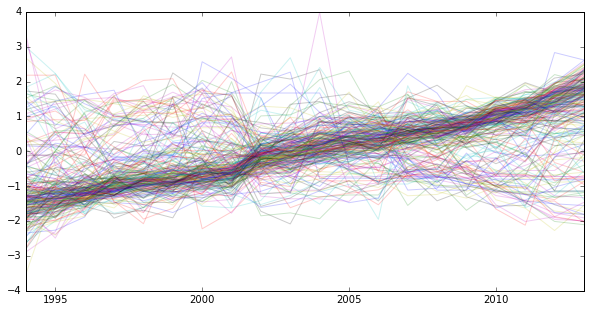

In [93]:
#subtract the mean and divide each time series (separately) by its standard deviation.

df_final = df_final.dropna()

mydata = df_final
for i in range(len(mydata)):
    mydata.iloc[i] = (mydata.iloc[i]-np.mean(mydata.iloc[i]))/np.std(mydata.iloc[i])

#print mydata.head()
dbb = mydata.copy()
#print dbb.head()
print "Sanity Check"
print "mean:", ("{0:.2f}".format(np.mean(mydata.iloc[i])))
print "std:", np.std(mydata.iloc[i])

pl.figure(figsize=(10,5))
pl.xlim(1994,2013)
for i in range(len(mydata)):
    pl.plot(mydata.iloc[i].index, mydata.iloc[i], alpha=0.2) 

[ 0.23989369  0.43780639  0.45158102  0.49634962  0.55239383  0.64832797
  0.73950977  0.57887228 -0.02078724 -0.12273784  0.09403085 -0.03820737
 -0.12928349 -0.2732822  -0.43371813 -0.55005887 -0.66919119 -0.80415819
 -0.6376703  -0.5596706 ] [1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1
 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1] (230,)


(1994, 2013)

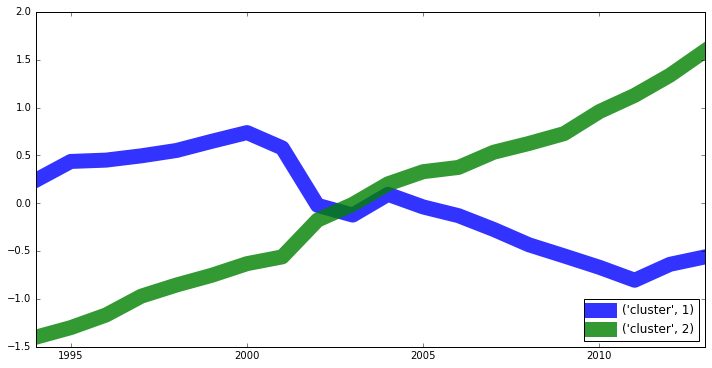

In [116]:
# Set k means start point, which is random
random.seed((123,456))

#Try 2 cluster first
mydata2= mydata
nk= 2
centroids_2, label_2 = kmeans2(np.asarray(mydata2), 2, iter=20, minit = 'points')

year = np.arange(1994,2014)
print centroids_2[0], label_2, label_2.shape
pl.figure(figsize=(12,6))

# plot
for i in range(len(centroids_2)):
    pl.plot(year, centroids_2[i], alpha=0.8, linewidth=15, label=('cluster',i+1)) 
pl.legend(loc=4)
pl.xlim(1994,2013)

In [117]:
geodata = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
geodata1 = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
geod = pd.DataFrame({'zip':geodata['postalCode'].astype(float)}).drop_duplicates()
#geod.head()
y = []
for i in range(1994,2014):
    #n= str(i)
    y.append(i)
l = []
for i in range(20):
    n='df'+str(i)
    l.append(n)
k=0
for i in range(94,100):
        if k<6:
            fname = 'zbp'+str(i)+'totals.zip'
            zf = zipfile.ZipFile(fname)
            name = 'df'+str(k)
            #l_z = zf.namelist()
            #print l and see which file to open
            our_text_file = zf.open('zbp'+str(i)+'totals.txt')
            globals()[name] = pd.read_csv(our_text_file)
            k=k+1           
for i in range(0,11):
         if k>=6 and k<16:   
            #print i
            fname = 'zbp0'+str(i)+'totals.zip'
            zf = zipfile.ZipFile(fname)
            #l_z = zf.namelist()
            #print l and see which file to open
            name = 'df'+str(k)
            our_text_file = zf.open('zbp0'+str(i)+'totals.txt')
            globals()[name] = pd.read_csv(our_text_file)
            k=k+1
            #print k    
for i in range(0,4):
        if k>=16:
            fname = 'zbp1'+str(i)+'totals.zip'
            zf = zipfile.ZipFile(fname)
            #l_z = zf.namelist()
            #print l and see which file to open
            name = 'df'+str(k)
            our_text_file = zf.open('zbp1'+str(i)+'totals.txt')
            globals()[name] = pd.read_csv(our_text_file)            
            k=k+1
f = df0[(df0['zip']>10000) & (df0['zip']<11692)]
data_f = geod
for i in range(20):
    
    name = 'data'+str(i)
    name_c = 'df'+str(i)
    df = globals()[name_c]
    if (i>3) and (i<9):
        #print i         
        df = df[['ZIP','EST']]
        df.columns = ['zip','est'+str(i)]
        df = pd.merge(geod,df,on='zip')
    else :
        df = df[['zip','est']]
        df.columns = ['zip','est'+str(i)]
        df = pd.merge(geod,df,on='zip')
    globals()[name] = df
    data_f['est'+str(i)] = df['est'+str(i)]
df_array = data_f.as_matrix()
badindex = []
for i,est in enumerate(df_array):
    if np.isnan(est).any():
        badindex.append(i)
        
clean_est = np.delete(df_array, badindex, 0)
cluster_array = []
zips = []
s = []
for i in range(224):
     nd = clean_est[i][1:]
     zips.append(clean_est[i][0])
     s.append(nd)
     nd_mean = np.mean(clean_est[i][1:])
     nd_std = np.std(clean_est[i][1:])
     for i in range(len(nd)):
         nd[i] = (nd[i]-nd_mean)/nd_std
     cluster_array.append(nd)
     clean_est[i][1:] = nd   

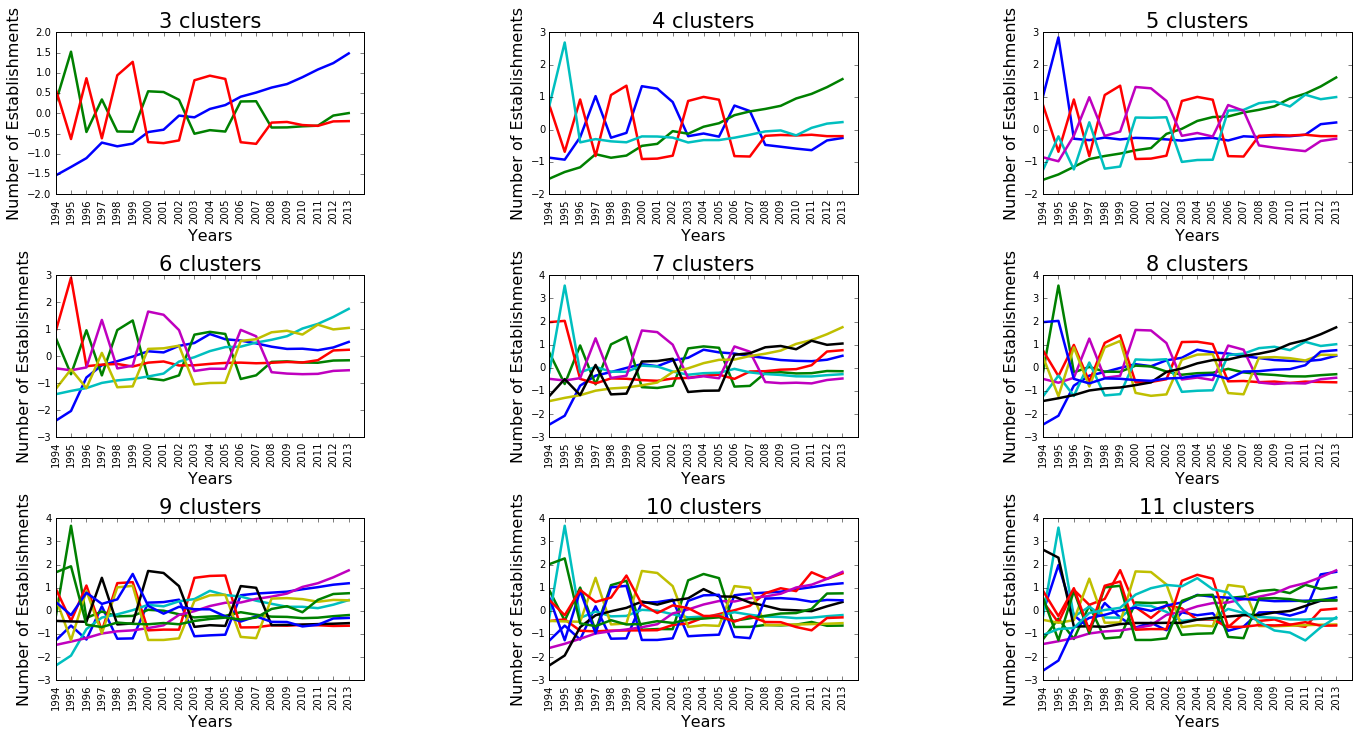

In [118]:
plt.figure(figsize=(18, 18), dpi=200)

p = 1
for i in range(3,12):

    est=k_means(s,n_clusters = i)
    plt.subplot(3, 3, p)
    p += 1
    plt.plot(range(20), np.transpose(est[0]),linewidth=2.5)
    plt.title(str(i)+' clusters', fontsize = 21)
    plt.ylabel('Number of Establishments', fontsize = 16)
    plt.xlabel('Years', fontsize = 16)
    plt.xticks(range(20), y, rotation = 90);
    plt.legend()
plt.subplots_adjust(wspace=.6, hspace=0.5, left=0, right=1, top=0.5, bottom=0)

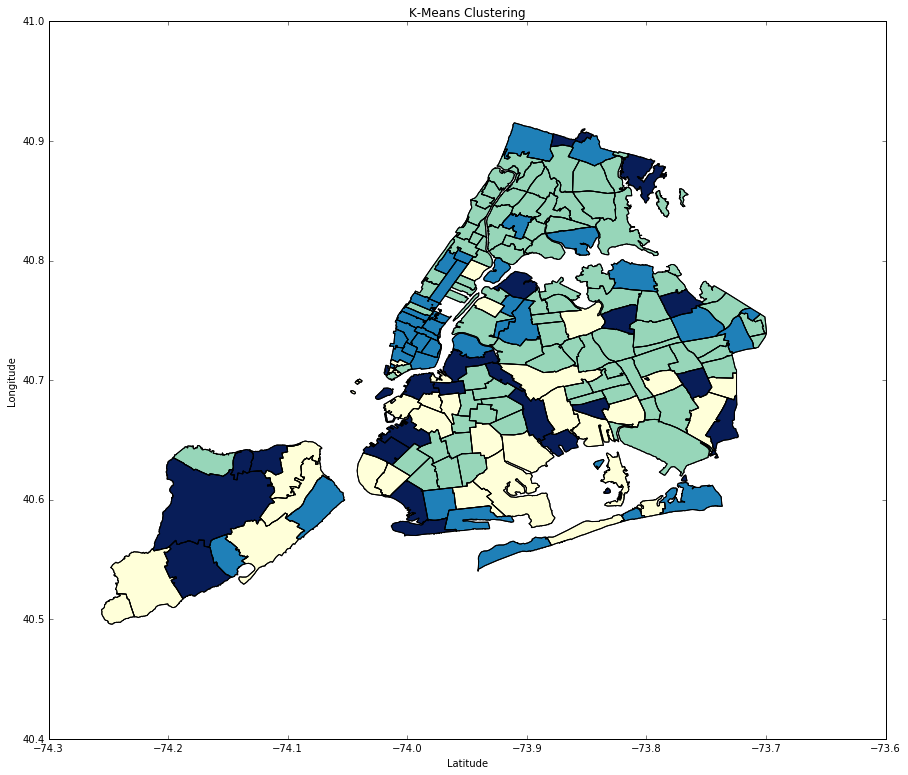

In [119]:
with_zip=pd.DataFrame()
with_zip['zip'] = zips

cl = cluster_array
with_zip['cluster'] = est[1]
col=['m','g','y','b','c']
c = k_means(cluster_array,n_clusters=5)

geodata['zip'] = geodata['postalCode'].astype(float)
hope = geodata.join(with_zip,rsuffix='zip',how='inner')

fig = plt.figure(figsize=(15,15))
hope.plot(column='cluster', scheme='QUANTILES', alpha=1, colormap='YlGnBu')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('K-Means Clustering')
#mplleaflet.display(crs =hope.crs)

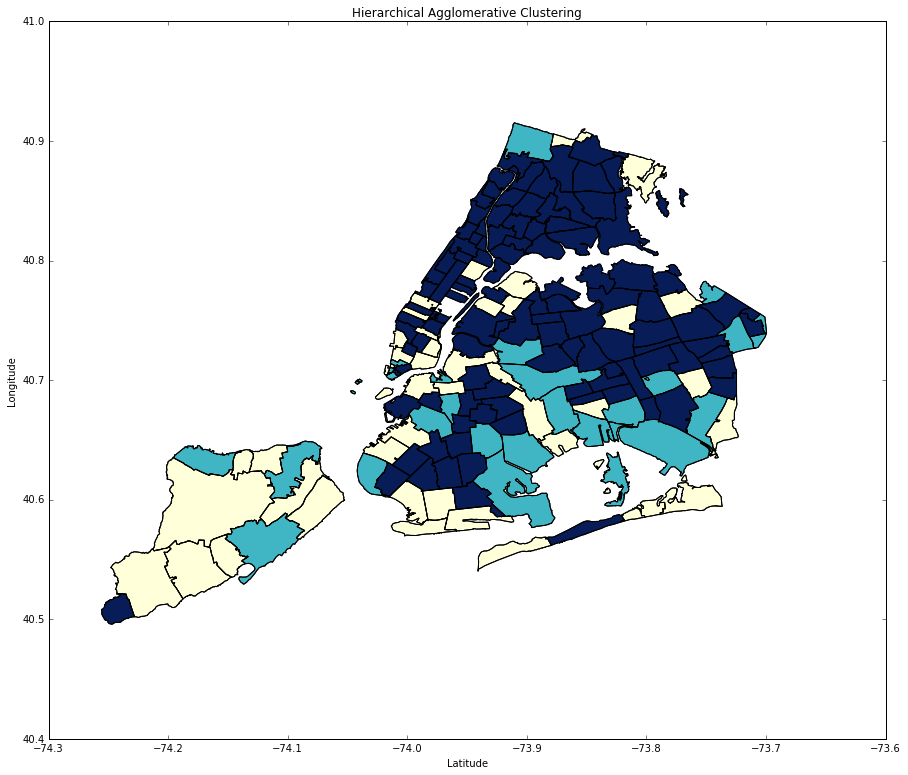

In [120]:
#Then using Hierarchical Agglomerative Clustering methods
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters=5, compute_full_tree=True).fit(s)
with_zip['cluster2'] = agc.labels_
geodata1['zip'] = geodata1['postalCode'].astype(float)
hope2 = geodata1.join(with_zip,rsuffix='zip',how='inner')
fig = plt.figure(figsize=(15,15))
hope2.plot(column='cluster2', scheme='QUANTILES', alpha=1, colormap='YlGnBu')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Hierarchical Agglomerative Clustering')

### Compare two methods

From the result of K-means and Hierarchical Agglomerative Clustering, It's hard to say which one is better. K means cluster is easy to apply, however its results depend on the starting point, which is random. The results might be very different every time we run it. So the results are somehow not reproductible. It also requires an initial 'guess' of the number of clusters.

Hierarchical Agglomerative Clustering is an algorithm that  treats each document as a singleton cluster at the outset and then successively merge (or agglomerate) pairs of clusters until all clusters have been merged into a single cluster that contains all documents, the advantage is that clusters generated in early stages are nested in those generated in later stages

### Interpretation

#### 1. From map of K-Means Clustering:

###### Yellow areas: 

Most of Staten Island along with areas between Brooklyn and Queens showed a fluctuating trend but are now gradually increasing in the number of establishments they have. 

###### Green Areas: 

Areas around Prospect Park, Upper Manhattan, Bronx and Queens show a steady increase in number of establishments, that may caused by the fact that more and more people tend to live in these places in recent years.

###### Blue Areas: 

Some parts of each borough have shown a peak in the past but now have almost no establishments.


#### 2. From map of Hierarchical Agglomerative Clustering:

It is almost the same as which from K-means Clustering, but the difference is that areas around Long Island and some parts of Brooklyn. 

#### Hence it is hard to say which method is better in this situation